## last version

In [113]:
import numpy as np
import random as rand
import math as m
from collections import deque
import heapq
import networkx as nx
import matplotlib.pyplot as plt
def neighbors(A, i):
    """
    Return the neighbors of the city i in the graph A.
    """
    return [j for j in range(len(A[i])) if A[i][j] == 1]




In [114]:
def C(A, phi, Temp, i, j, t, amplitude, offset, frequency):
    """
    Cost function between the cities i and j at time t.

    @param A: Graph of the cities.
    @param phi: Initial phases
    @param Temp: Initial values to simulate randomness.
    @param i: City of departure.
    @param j: City of arrival.
    @param t: Time.
    @param amplitude: Amplitude of the cost function.
    @param offset: Offset of the cost function.
    @param frequency: Frequency of the cost function.
    """
    return max(1, round((amplitude * m.sin(frequency * t + phi[i][j]) + offset) * Temp[i][j], 4)) if A[i][j] == 1 else float('inf')

In [115]:
def collect(P, r):
    """
    Mark the object m from the request r as collected.
    """
    P[r[0]][r[1]] = 1


In [116]:
def deliver(D, r):
    """
    Mark the object m from the request r as delivered.
    """
    D[r[0]][r[1]] = 1

In [117]:
def check_delivery_done(R, D):
    """
    Check if all the deliveries have been done.
    """
    for request in R : 
        if request not in D:
            return False 
    return True 

In [118]:
def connexity(A):
    n = len(A)
    visited = np.zeros(n, dtype=bool)
    stack = [0] 
    visited[0] = True

    while stack:
        node = stack.pop()
        neighbors = np.nonzero(A[node])[0]
        for i in neighbors:
            if not visited[i]:
                stack.append(i)
                visited[i] = True

    return np.all(visited)

In [119]:
def generate_random_symetrical_boolean_graph(n):
    """
    Generate a random symetrical graph with n nodes. There is at least one edge between two nodes.
    """
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1)
    A += A.T  

    if(not connexity(A)):
        A = generate_random_symetrical_boolean_graph(n)

    A_tuple = tuple(map(tuple, A))
    return A_tuple

In [120]:
def generate_random_symetrical_weighted_graph(n, min, max):
    """
    Generate a random symetrical weighted graph with n nodes.
    """
    A = np.random.uniform(min, max, (n, n))
    A = np.triu(A, 1)
    A += A.T  
    A_tuple = tuple(map(tuple, A))
    return A_tuple

In [121]:
def generate_random_collect_points(cities):
    """
    Generate a random list of cities where the vehicle will collect the packages.
    """
    collect_points = np.random.randint(0, 2, cities)
    return collect_points

In [122]:
def generate_random_delivery_requests(cities, collect_points):
    """
    Generate a random list of cities where the vehicle will deliver the packages.
    """
    drop_points = set()
    for i, collect in enumerate(collect_points):
        if collect:
            number_of_drop_points = rand.randint(0, cities - 1)
            drop_points.update((i, rand.randint(0, cities - 1)) for _ in range(number_of_drop_points))
    return sorted(drop_points)


 Deliveries:
Object from city 1 need to be deliver in city: 0
Object from city 1 need to be deliver in city: 4
Object from city 1 need to be deliver in city: 5
Object from city 1 need to be deliver in city: 6
Object from city 1 need to be deliver in city: 8
Object from city 1 need to be deliver in city: 9
Object from city 5 need to be deliver in city: 0
Object from city 5 need to be deliver in city: 1
Object from city 5 need to be deliver in city: 2
Object from city 5 need to be deliver in city: 4
Object from city 5 need to be deliver in city: 6
Object from city 5 need to be deliver in city: 7
Object from city 9 need to be deliver in city: 2
Object from city 9 need to be deliver in city: 4

Best path starting from city 4 : [4]
Cost of best path: 0

Edge weights for the best path:


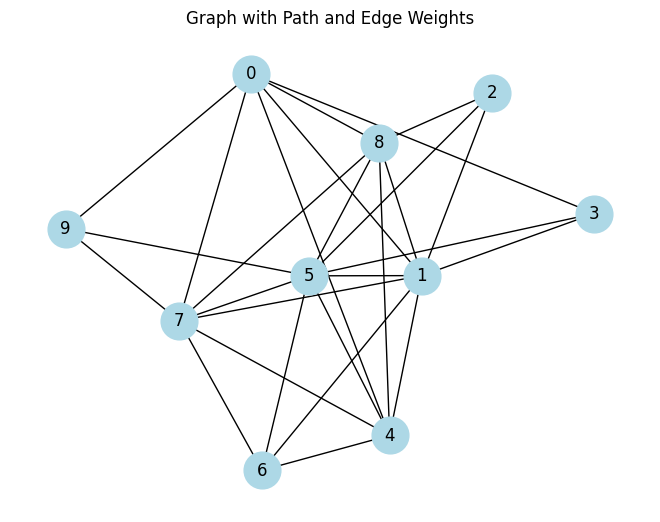

In [123]:
# Constants for the ACO algorithm
NB_FOURMIS = 100  # Number of ants
NB_ITERATIONS = 100  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited


def initialize_pheromones(A,initial_pheromone):
    n = len(A)
    weights = np.random.uniform(initial_pheromone, initial_pheromone, (n, n))
    weighted_graph = np.multiply(A, weights)
    return weighted_graph

def update_pheromones(pheromones, paths, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any([city in deliveries for obj in deliveries]))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries))
    pheromones *= (1 - RHO)
    return pheromones

def construct_path(graph, pheromones, weights, deliveries, start_city, phi, Temp, amplitude, offset, frequency):
    n=len(graph)
    path = [start_city]  # Start at the initial city
    cost = 0
    visited = set([start_city])
    collect_points = set()
    delivered_items = set()

    t = 0  # Initialize time for dynamic cost calculation
    all_deliveries= [j for i,j in deliveries]
    all_collect_points = [i for i,j in deliveries]
    while True:
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and i not in visited]

        filtered_choices = []
        for i in choices:
            if i in all_deliveries and any([item not in collect_points for item in all_collect_points]):
                continue  # Skip delivery locations if the required items are not collected yet
            dynamic_cost = C(graph, phi, Temp, current, i, t, amplitude, offset, frequency)
            if dynamic_cost != float('inf'):
                filtered_choices.append(i)

        if not filtered_choices:
            if current != start_city:
                filtered_choices = [start_city]  # Force return to start if stuck
            else:
                break

        probabilities = [pheromones[current][i] ** ALPHA * (1.0 / weights[current][i]) ** BETA for i in filtered_choices]
        total = sum(probabilities)
        if total == 0:
            next_city=start_city
        else:
            probabilities = [p / total for p in probabilities]
            next_city = rand.choices(filtered_choices, weights=probabilities, k=1)[0]
            
        path.append(next_city)
        visited.add(next_city)
        cost += weights[current][next_city]  # Use actual weights for cost evaluation

        # Check and update collections and deliveries
        if next_city in collect_points:
            all_collect_points.update(next_city)

        for item, location in deliveries:
            if next_city == location and item in collect_points:
                all_deliveries.append((item,location))

        t += 1

        if check_delivery_done(deliveries, all_deliveries) and next_city == start_city:
            break

    return path, cost

def ant_colony_optimization(graph, weights, deliveries, phi, Temp, amplitude, offset, frequency):
    start_city = rand.randint(0, n-1)
    pheromones = initialize_pheromones(graph, 0.1)
    
    all_deliveries= [j for i,j in deliveries]
    all_collect_points = [i for i,j in deliveries]
    best_path, best_cost = None, float('inf')
    
    for _ in range(NB_ITERATIONS):
        paths = [construct_path(graph, pheromones, weights, deliveries, start_city, phi, Temp, amplitude, offset, frequency) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if check_delivery_done(path, all_deliveries)]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, all_deliveries)
    return best_path, best_cost, start_city

def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()

if __name__ == '__main__':
    n = 10
    min_weight = 1
    max_weight = 10
    phi = generate_random_symetrical_weighted_graph(n, 0.5, 5)  # Initial phase 
    Temp = generate_random_symetrical_weighted_graph(n, 0, 20)  # Initial random values
    amplitude = 0.7 
    offset = 0.3
    frequency = 0.5
    
    graph = generate_random_symetrical_boolean_graph(n)
    weights = generate_random_symetrical_weighted_graph(n, min_weight, max_weight)
    collect_points = generate_random_collect_points(n)
    deliveries = generate_random_delivery_requests(n, collect_points)
    print("\n Deliveries:")
    for delivery in deliveries:
        print(f"Object from city {int(delivery[0])} need to be deliver in city: {int(delivery[1])}")
    


    best_path, best_cost, start_city = ant_colony_optimization(graph, weights, deliveries, phi, Temp, amplitude, offset, frequency)
    if best_path is not None:
        print("\nBest path starting from city", start_city, ":", best_path)
        print("Cost of best path:", best_cost)
        print("\nEdge weights for the best path:")
        for i in range(len(best_path) - 1):
            print(f"Edge from {best_path[i]} to {best_path[i+1]} with weight {weights[best_path[i]][best_path[i+1]]}")
        draw_graph_with_path_and_weights(graph, best_path, weights)
    else:
        print("No valid path was found that meets all delivery requirements.")



## algo des fourmis fonctionnel V2 : 

In [124]:
import numpy as np
import random as rand
import math as m
import networkx as nx
import matplotlib.pyplot as plt

# Constants for the ACO algorithm
NB_FOURMIS = 100  # Number of ants
NB_ITERATIONS = 100  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited

def initialize_pheromones(A, initial_pheromone):
    n = len(A)
    weights = np.random.uniform(initial_pheromone, initial_pheromone, (n, n))
    weighted_graph = np.multiply(A, weights)
    return weighted_graph

In [125]:
def update_pheromones(pheromones, paths, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any([city in deliveries for obj in deliveries]))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries))
    pheromones *= (1 - RHO)
    return pheromones

In [126]:

def check_delivery_done(R, D):
    """
    Check if all the deliveries have been done.
    """
    return all(item in D for item in R)

In [127]:
def construct_path(graph, pheromones, weights, deliveries, start_city, phi, Temp, amplitude, offset, frequency):
    n = len(graph)
    path = [start_city]  # Start at the initial city
    cost = 0
    visited = set([start_city])
    collected_items = set()
    delivered_items = set()

    t = 0  # Initialize time for dynamic cost calculation
    all_deliveries = [j for i, j in deliveries]
    all_collect_points = [i for i, j in deliveries]

    while True:
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and i not in visited]

        filtered_choices = []
        for i in choices:
            if i in all_deliveries and any([item not in collected_items for item in all_collect_points]):
                continue  # Skip delivery locations if the required items are not collected yet
            dynamic_cost = C(graph, phi, Temp, current, i, t, amplitude, offset, frequency)
            if dynamic_cost != float('inf'):
                filtered_choices.append(i)

        if not filtered_choices:
            if current != start_city:
                filtered_choices = [start_city]  # Force return to start if stuck
            else:
                break

        probabilities = [pheromones[current][i] ** ALPHA * (1.0 / weights[current][i]) ** BETA for i in filtered_choices]
        total = sum(probabilities)
        if total == 0:
            next_city = start_city
        else:
            probabilities = [p / total for p in probabilities]
            next_city = rand.choices(filtered_choices, weights=probabilities, k=1)[0]

        path.append(next_city)
        visited.add(next_city)
        cost += weights[current][next_city]  # Use actual weights for cost evaluation

        # Check and update collections and deliveries
        if next_city in all_collect_points:
            collected_items.add(next_city)

        for item, location in deliveries:
            if next_city == location and item in collected_items:
                delivered_items.add((item, location))

        t += 1

        if check_delivery_done(deliveries, delivered_items) and next_city == start_city:
            break

    return path, cost

In [128]:
def find_backup_path(graph, deliveries, start_city):
    n = len(graph)
    path = [start_city]
    visited = set(path)
    for item, location in deliveries:
        if location not in visited:
            path.append(location)
            visited.add(location)
    path.append(start_city)
    return path

In [129]:
def ant_colony_optimization(graph, weights, deliveries, phi, Temp, amplitude, offset, frequency):
    start_city = rand.randint(0, len(graph) - 1)
    pheromones = initialize_pheromones(graph, 0.1)
    all_deliveries = [j for i, j in deliveries]
    all_collect_points = [i for i, j in deliveries]
    best_path, best_cost = None, float('inf')

    for _ in range(NB_ITERATIONS):
        paths = [construct_path(graph, pheromones, weights, deliveries, start_city, phi, Temp, amplitude, offset, frequency) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if check_delivery_done(all_deliveries, path)]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries)

    if best_path is None:
        best_path = find_backup_path(graph, deliveries, start_city)
        best_cost = sum(weights[best_path[i]][best_path[i+1]] for i in range(len(best_path) - 1))

    return best_path, best_cost, start_city

In [130]:
def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()


 Deliveries:
Object from city 0 need to be deliver in city: 1
Object from city 0 need to be deliver in city: 3
Object from city 0 need to be deliver in city: 7
Object from city 0 need to be deliver in city: 9
Object from city 1 need to be deliver in city: 0
Object from city 1 need to be deliver in city: 3
Object from city 1 need to be deliver in city: 9
Object from city 2 need to be deliver in city: 5
Object from city 2 need to be deliver in city: 6
Object from city 2 need to be deliver in city: 8
Object from city 4 need to be deliver in city: 5
Object from city 4 need to be deliver in city: 8
Object from city 4 need to be deliver in city: 9
Object from city 5 need to be deliver in city: 1
Object from city 6 need to be deliver in city: 9
Object from city 8 need to be deliver in city: 0
Object from city 8 need to be deliver in city: 1
Object from city 8 need to be deliver in city: 5
Object from city 8 need to be deliver in city: 7

Best path starting from city 6 : [6, 1, 3, 7, 9, 0, 5,

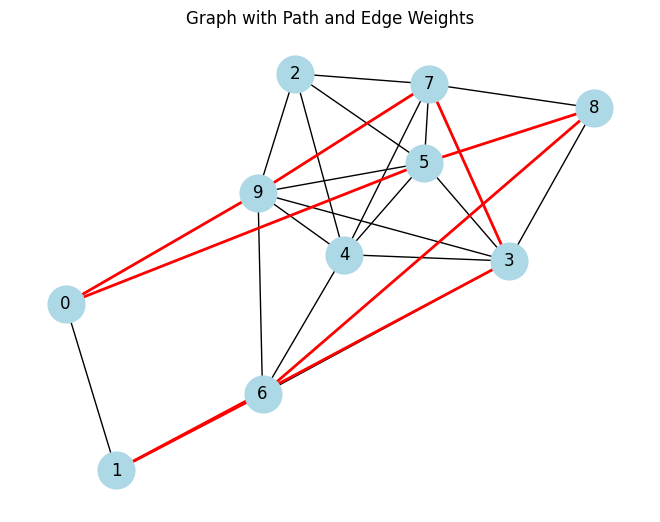

In [131]:
if __name__ == '__main__':
    n = 10
    min_weight = 1
    max_weight = 10
    phi = generate_random_symetrical_weighted_graph(n, 0.5, 5)  # Initial phase 
    Temp = generate_random_symetrical_weighted_graph(n, 0, 20)  # Initial random values
    amplitude = 0.7 
    offset = 0.3
    frequency = 0.5
    
    graph = generate_random_symetrical_boolean_graph(n)
    weights = generate_random_symetrical_weighted_graph(n, min_weight, max_weight)
    collect_points = generate_random_collect_points(n)
    deliveries = generate_random_delivery_requests(n, collect_points)
    print("\n Deliveries:")
    for delivery in deliveries:
        print(f"Object from city {int(delivery[0])} need to be deliver in city: {int(delivery[1])}")

    best_path, best_cost, start_city = ant_colony_optimization(graph, weights, deliveries, phi, Temp, amplitude, offset, frequency)
    if best_path:
        print("\nBest path starting from city", start_city, ":", best_path)
        print("Cost of best path:", best_cost)
        print("\nEdge weights for the best path:")
        for i in range(len(best_path) - 1):
            print(f"Edge from {best_path[i]} to {best_path[i+1]} with weight {weights[best_path[i]][best_path[i+1]]}")
        draw_graph_with_path_and_weights(graph, best_path, weights)
    else:
        print("No valid path was found that meets all delivery requirements.")
